In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import sys 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../../src')
import warnings
import gc
warnings.filterwarnings('ignore')

# from spaceoracle.prophets import Prophet
from spaceoracle.gene_factory import GeneFactory

In [3]:
import getpass
whoami = getpass.getuser()

if whoami == 'koush':
    base_dir = '/Users/koush/Desktop/training_data/'
elif whoami == 'ally':
    base_dir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/data'
else:
    base_dir = '/ix/djishnu/shared/djishnu_kor11/training_data_2025/'

adata_path = f'{base_dir}/snrna_human_tonsil.h5ad'
adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2'
    uns: 'author_cell_type_colors', 'cell_thresholds', 'cell_type_2_colors', 'cell_type_colors', 'dendrogram_leiden', 'leiden', 'leiden_R', 'leiden_colors', 'ligand_receivers', 'neighbors', 'pca', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [4]:
pd.read_json(
    '/Volumes/SSD/human_tonsil/run_params.json', 
    orient='index').to_dict()[0]

{'timestamp': '2025-03-10 22:23:54.935746',
 'max_epochs': 100,
 'spatial_dim': 64,
 'learning_rate': 0.005,
 'batch_size': 512,
 'rotate_maps': True,
 'threshold_lambda': 1e-06,
 'tf_ligand_cutoff': 0.01,
 'radius': 200,
 'contact_distance': 30,
 'annot': 'cell_type_int',
 'layer': 'imputed_count',
 'save_dir': '/ix/djishnu/shared/djishnu_kor11/lasso_runs/human_tonsil',
 'n_genes': 3549}

In [5]:
adata.obs.cell_type_2.value_counts()

cell_type_2
GC B           1581
B memory        873
B naive         715
CD4+ T          530
Plasma          490
Tfh             404
T memory        371
fDC             200
CD8+ T          175
pDC             172
mDC             122
Macrophages      98
DN T             47
Name: count, dtype: int64

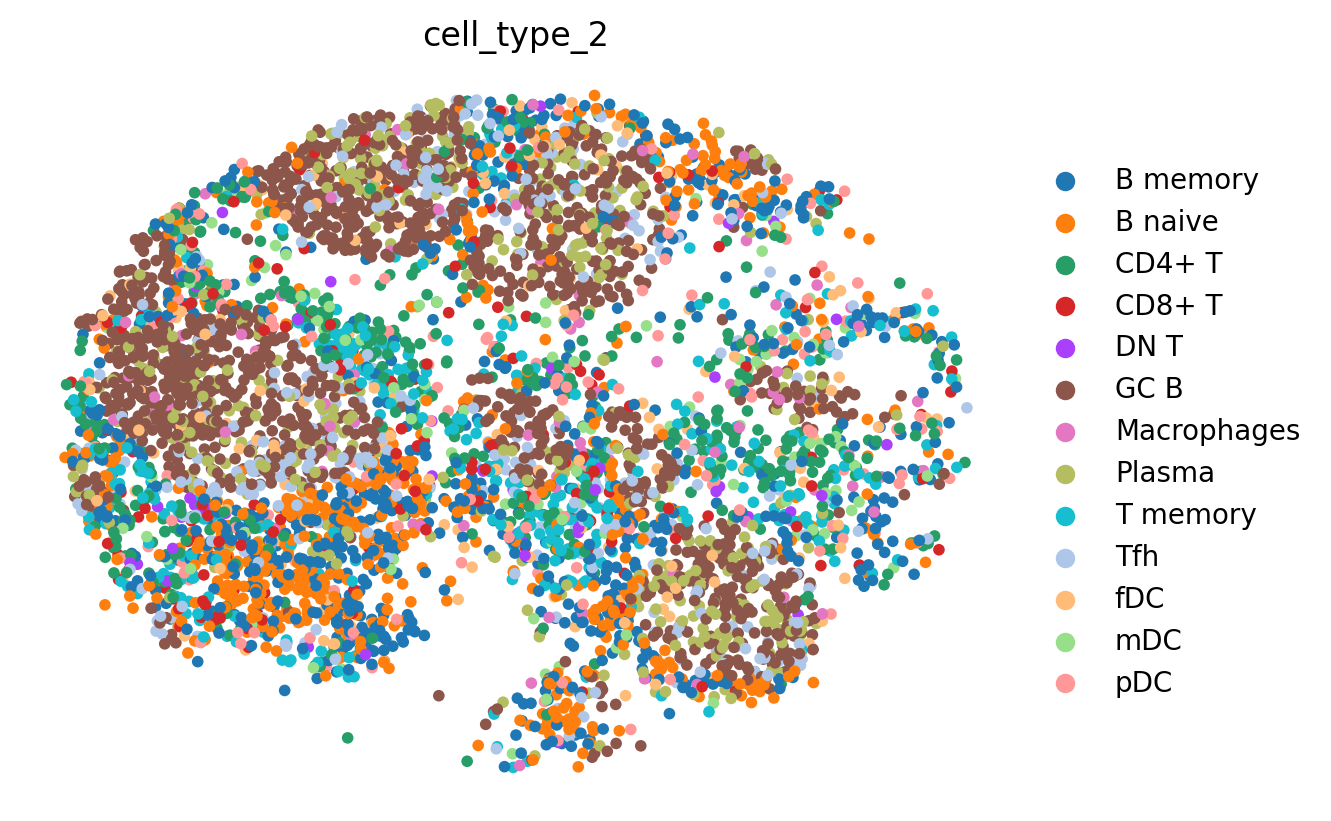

In [6]:
sc.pl.embedding(adata, color=['cell_type_2'], frameon=False, basis='spatial', s=70)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


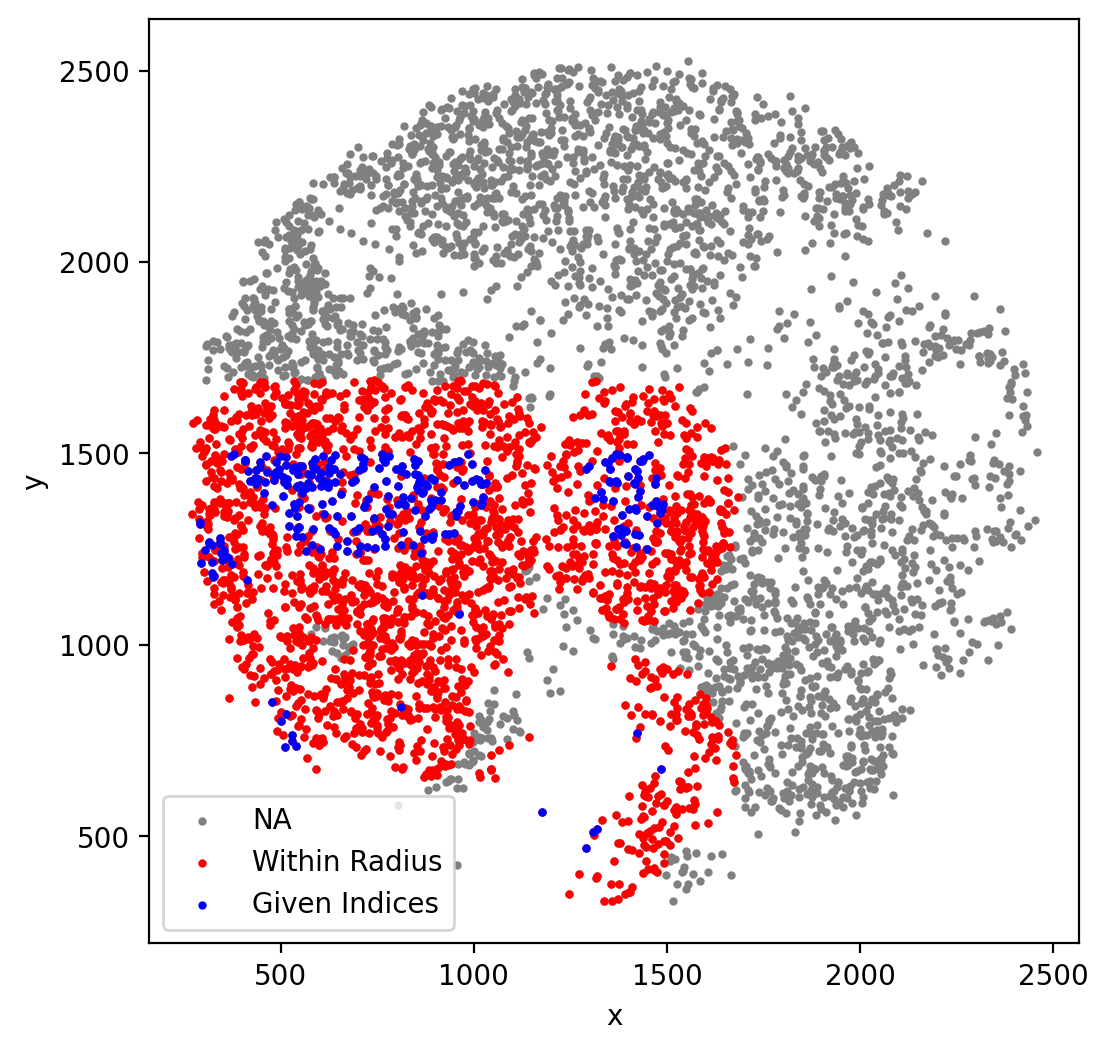

(2523, 5778)

In [7]:

plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 100

from spaceoracle.plotting.cartography import xy_from_adata, plot_cells
xy = xy_from_adata(adata)

indices = adata[
    (adata.obs.cell_type_2.isin(
        [
            'GC B', 
        ])
    ) & (xy.y < 1500) & (xy.x < 1500)].obs_names

radius = 200
cells_within_radius = plot_cells(xy, indices, radius)
len(cells_within_radius), adata.shape[0]

In [8]:
adata

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2'
    uns: 'author_cell_type_colors', 'cell_thresholds', 'cell_type_2_colors', 'cell_type_colors', 'dendrogram_leiden', 'leiden', 'leiden_R', 'leiden_colors', 'ligand_receivers', 'neighbors', 'pca', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [23]:
adata_subset = adata[cells_within_radius]
adata_subset

View of AnnData object with n_obs × n_vars = 2523 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2'
    uns: 'author_cell_type_colors', 'cell_thresholds', 'cell_type_colors', 'dendrogram_leiden', 'leiden', 'leiden_R', 'leiden_colors', 'ligand_receivers', 'neighbors', 'pca', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [10]:
adata_subset.obs.cell_type.value_counts()

cell_type
GC B           557
B memory       436
B naive        431
T cells        327
CD4+ T         203
Tfh            195
DC             177
Plasma         162
Macrophages     35
Name: count, dtype: int64

In [11]:
gf = GeneFactory.from_json(
    adata_subset, 
    '/Volumes/SSD/human_tonsil/run_params.json', 
    override_params={'save_dir': '/Volumes/SSD/human_tonsil'}
)

assert len(gf.queue.remaining_genes) == 0

In [17]:
gf.load_betas(float16=True, subsample=1)

/Users/koush/Projects/SpaceOracle/notebooks/human_tonsil/../../src/spaceoracle/beta.py:68: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.tfs = []
/Users/koush/Projects/SpaceOracle/notebooks/human_tonsil/../../src/spaceoracle/beta.py:69: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.lr_pairs = []
/Users/koush/Projects/SpaceOracle/notebooks/human_tonsil/../../src/spaceoracle/beta.py:70: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.tfl_pairs = []
/Users/koush/Projects/SpaceOracle/notebooks/human_tonsil/../../src/spaceoracle/beta.py:87: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see h

In [24]:
adata_subset.uns['cell_thresholds'].shape, adata_subset.shape

((5778, 958), (2523, 3549))

In [18]:
gex_out = gf.perturb(
    target='FOXO1', 
    n_propagation=1, 
    gene_expr=0, 
    save_layer=False, 
    cells=None, 
    delta_dir=None
)

In [17]:
import decoupler as dc
import numpy as np

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
import commot as ct
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species=gf.species, 
        signaling_type=None
    )
    
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  


In [9]:
adata.X = adata.layers['imputed_count'].copy()

In [10]:
df = pd.read_parquet('/Users/koush/Projects/SpaceOracle/data/human_msigdb.parquet')
labels = df['label'].unique()
for label in labels:
    if label in df.columns:
        df.loc[df['label'] == label, 'label'] = f'_{label}'
df = df[['genesymbol', 'label', 'value', 'record_id']]
df = df.pivot(index=["genesymbol", "record_id"], columns="label", values="value").reset_index()
df.index.name = ''
df.columns.name = ''
cols_to_remove = ['record_id', 'entity_type']
df = df.drop(columns=[c for c in cols_to_remove if c in df.columns])
df = df.infer_objects()
df = df.convert_dtypes()

In [11]:
df.collection.unique()

<StringArray>
[                       'immunesigdb',                  'tf_targets_legacy',
                         'positional',               'cell_type_signatures',
              'go_cellular_component', 'chemical_and_genetic_perturbations',
                'mirna_targets_mirdb',                   'vaccine_response',
                     'cancer_modules',                  'reactome_pathways',
                    'tf_targets_gtrf',              'go_biological_process',
              'go_molecular_function',               'oncogenic_signatures',
                           'hallmark',                      'kegg_pathways',
                       'pid_pathways',           'human_phenotype_ontology',
                       'wikipathways',          'cancer_gene_neighborhoods',
               'mirna_targets_legacy',                  'biocarta_pathways']
Length: 22, dtype: string

In [12]:
db = df.query("collection.isin(['kegg_pathways', 'reactome_pathways'])")
db = db[~db.duplicated(("geneset", "genesymbol"))]

In [110]:
adata_ko = adata.copy()
adata_ko.X = pd.read_parquet(
    '/Volumes/SSD/genome_screens/human_tonsil/CXCR4_4n_0x.parquet').values

In [111]:
%%time

dc.run_aucell(
    adata_ko,
    db,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

dc.run_aucell(
    adata,
    db,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

CPU times: user 1min 6s, sys: 24.3 s, total: 1min 30s
Wall time: 19.4 s


In [112]:
pathways = np.intersect1d(
    adata.obsm['aucell_estimate'].columns, adata_ko.obsm['aucell_estimate'].columns)
adata.obs[pathways] = adata.obsm['aucell_estimate'][pathways]
adata_ko.obs[pathways] = adata_ko.obsm['aucell_estimate'][pathways]
kegg = [i for i in pathways if 'KEGG' in i]
reactome = [i for i in pathways if 'REACTOME' in i]

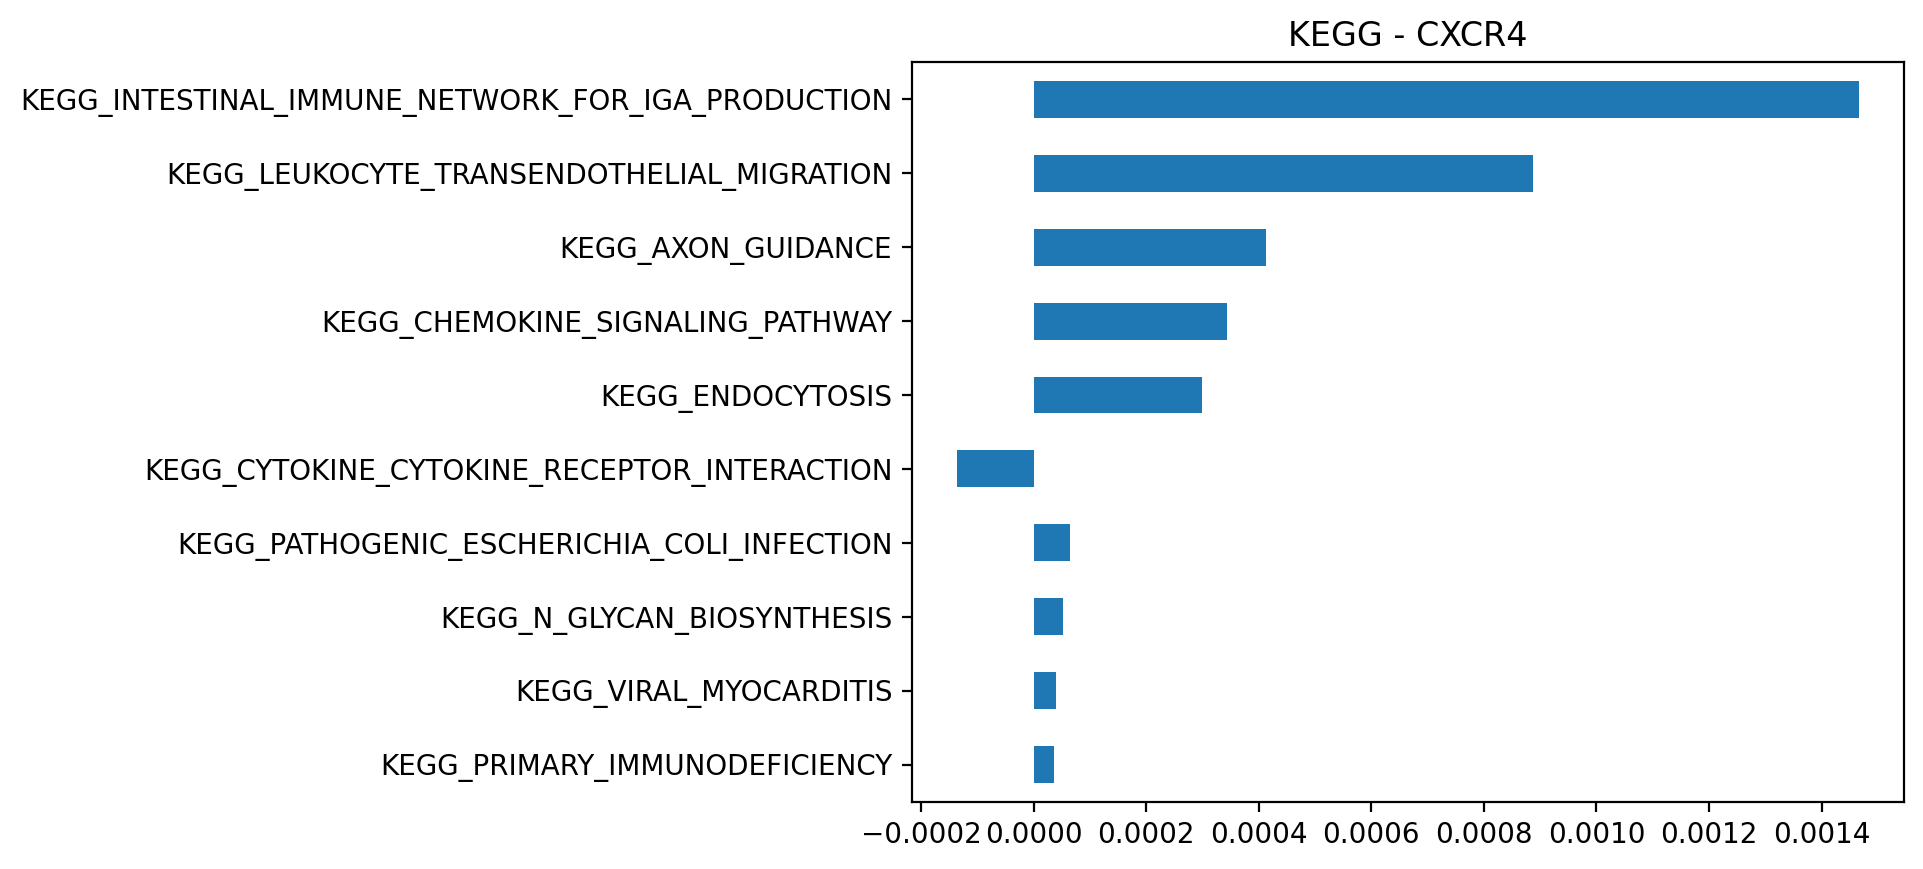

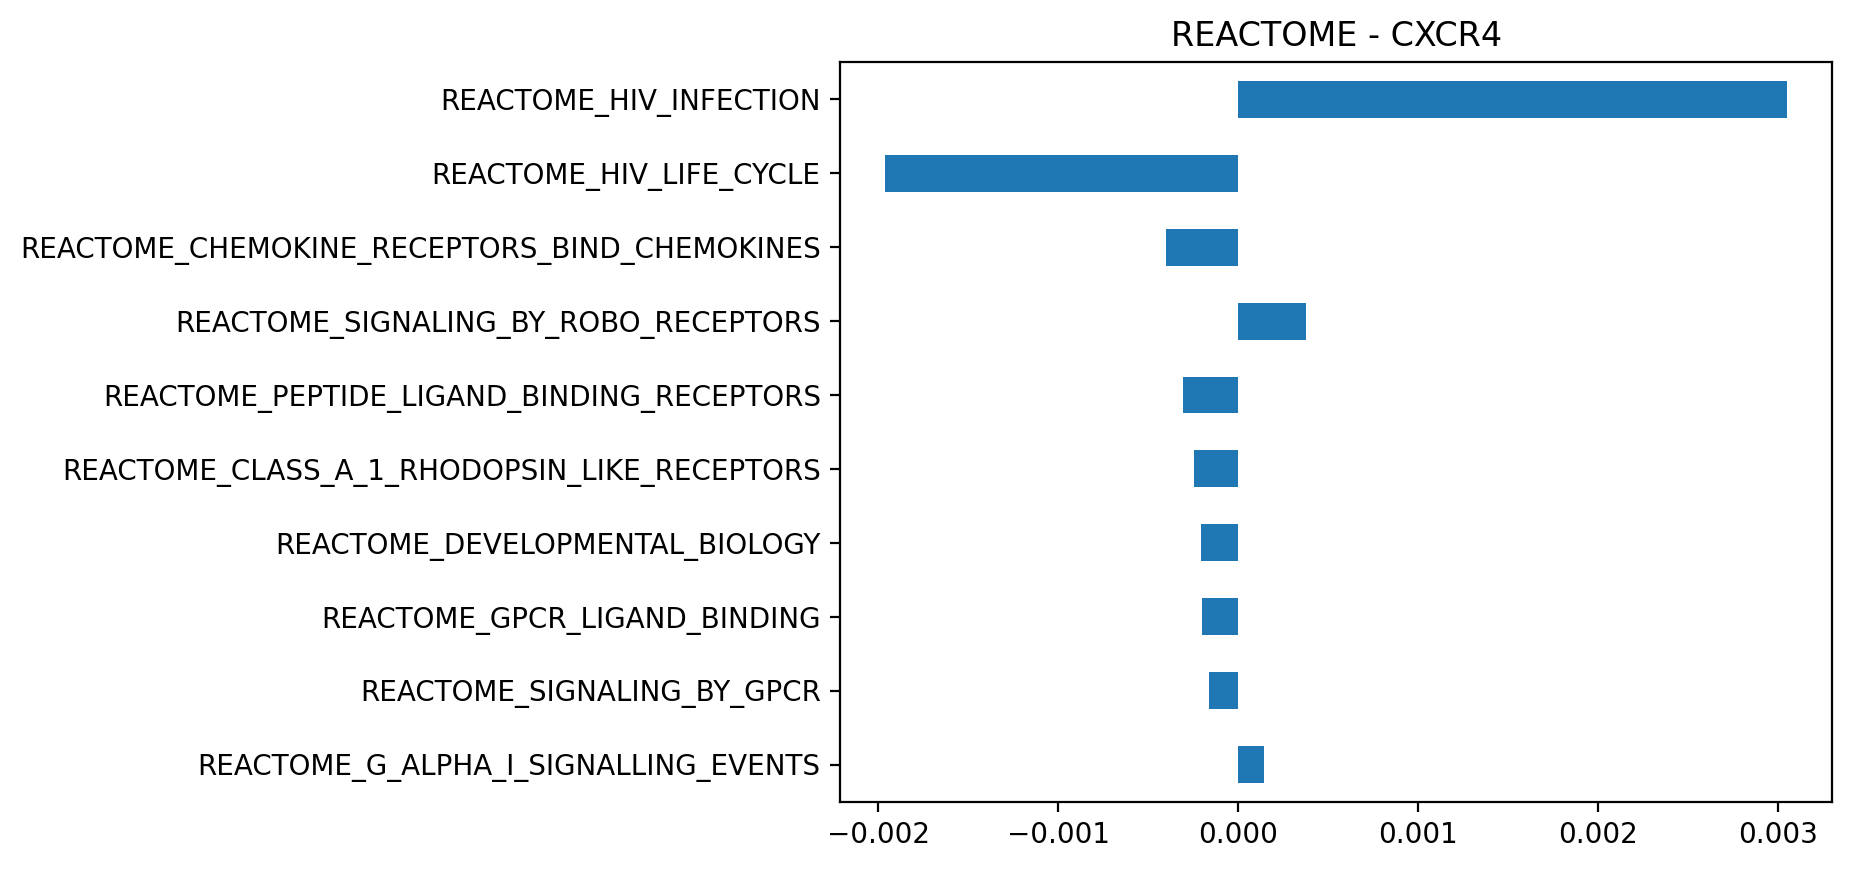

In [113]:
(adata_ko.obs[kegg] - adata.obs[kegg]).mean().sort_values(ascending=True, key=abs).tail(10).plot.barh()
plt.title('KEGG - CXCR4')
plt.show()
(adata_ko.obs[reactome] - adata.obs[reactome]).mean().sort_values(ascending=True, key=abs).tail(10).plot.barh()
plt.title('REACTOME - CXCR4')
plt.show()

In [114]:
adata_ko.obs[reactome] = adata_ko.obs[reactome] - adata.obs[reactome]
adata_ko.obs[kegg] = adata_ko.obs[kegg] - adata.obs[kegg]

In [115]:
adata_ko.obs[reactome].mean().sort_values(ascending=False, key=abs).head(10).index

Index(['REACTOME_HIV_INFECTION', 'REACTOME_HIV_LIFE_CYCLE',
       'REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES',
       'REACTOME_SIGNALING_BY_ROBO_RECEPTORS',
       'REACTOME_PEPTIDE_LIGAND_BINDING_RECEPTORS',
       'REACTOME_CLASS_A_1_RHODOPSIN_LIKE_RECEPTORS',
       'REACTOME_DEVELOPMENTAL_BIOLOGY', 'REACTOME_GPCR_LIGAND_BINDING',
       'REACTOME_SIGNALING_BY_GPCR', 'REACTOME_G_ALPHA_I_SIGNALLING_EVENTS'],
      dtype='object')

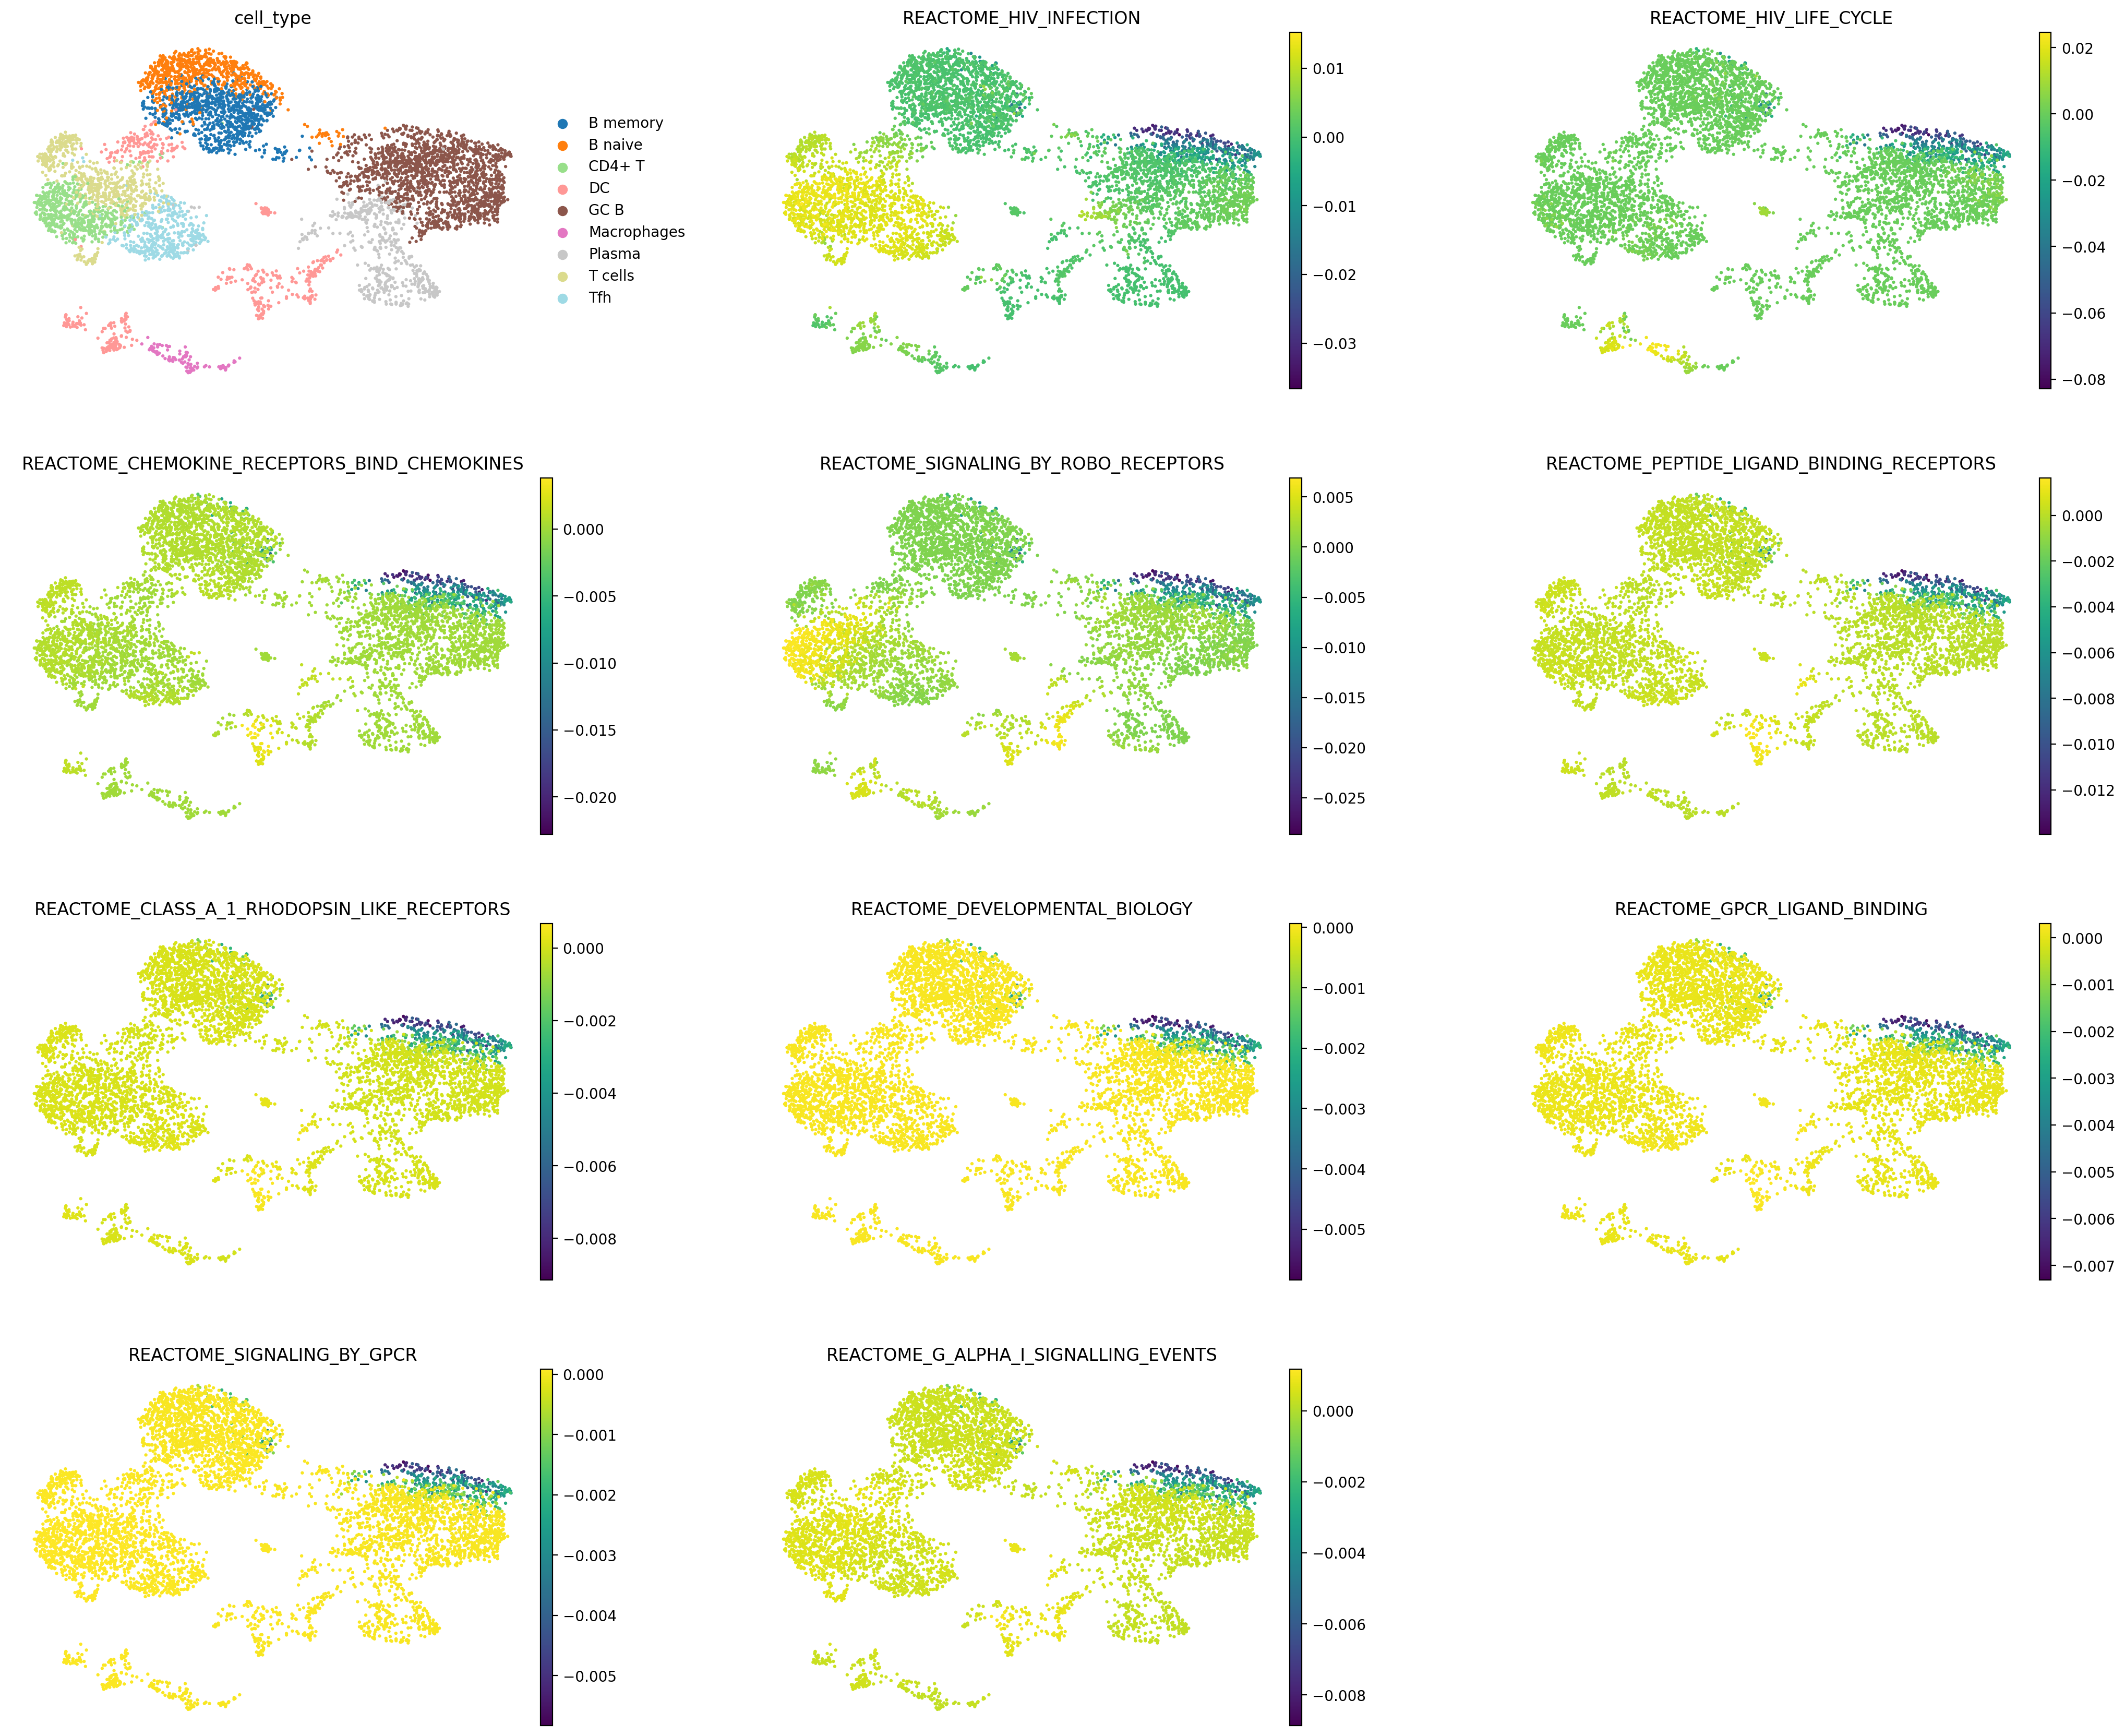

In [116]:
sc.pl.umap(
    adata_ko,
    color=["cell_type"] + ['REACTOME_HIV_INFECTION', 'REACTOME_HIV_LIFE_CYCLE',
       'REACTOME_CHEMOKINE_RECEPTORS_BIND_CHEMOKINES',
       'REACTOME_SIGNALING_BY_ROBO_RECEPTORS',
       'REACTOME_PEPTIDE_LIGAND_BINDING_RECEPTORS',
       'REACTOME_CLASS_A_1_RHODOPSIN_LIKE_RECEPTORS',
       'REACTOME_DEVELOPMENTAL_BIOLOGY', 'REACTOME_GPCR_LIGAND_BINDING',
       'REACTOME_SIGNALING_BY_GPCR', 'REACTOME_G_ALPHA_I_SIGNALLING_EVENTS'],
    frameon=False,
    ncols=3,
    wspace=0.3,
    show=False,
    return_fig=True
)
plt.show()

In [140]:
import glob
from tqdm.notebook import tqdm

In [148]:
pd.read_parquet(path)

Unnamed: 0            FAM41C   PLEKHN1   TNFRSF4    SCNN1D    INTS11  \
ARNTL_4n_0x                                                            
AAACCCAAGCGCCTTG-1  0.007975  0.014631  0.000000  0.001040  0.128363   
AAACCCAAGTGGACGT-1  0.001106  0.061053  0.001125  0.000371  0.233764   
AAACCCACAGAAGTGC-1  0.000493  0.002830  0.001344  0.003795  0.138898   
AAACCCAGTCATTGCA-1  0.002308  0.005750  0.031465  0.000113  0.138704   
AAACCCATCATCGCAA-1  0.001194  0.000472  0.000380  0.038023  0.082726   
...                      ...       ...       ...       ...       ...   
TTTGTTGCAGGGACTA-1  0.000615  0.000175  0.001221  0.001132  0.207552   
TTTGTTGCATTGTAGC-1  0.001231  0.053356  0.000000  0.000388  0.077077   
TTTGTTGGTACCACGC-1  0.000247  0.000058  0.000671  0.000843  0.176531   
TTTGTTGGTCTGTCCT-1  0.007252  0.007711  0.000000  0.000000  0.081658   
TTTGTTGTCATGCGGC-1  0.005089  0.003375  0.001475  0.000796  0.096737   

Unnamed: 0            ATAD3C       SKI     PEX10     PLCH2    PRXL2B  ...  \
ARNTL_4n_0x                                                           ...   
AAACCCAAGCGCCTTG-1  0.000000  0.577024  0.035410  0.062606  0.061723  ...   
AAACCCAAGTGGACGT-1  0.018101  0.084464  0.086222  0.008995  0.009999  ...   
AAACCCACAGAAGTGC-1  0.000276  0.063677  0.063532  0.003066  0.000000  ...   
AAACCCAGTCATTGCA-1  0.012778  0.562637  0.083558  0.027456  0.029455  ...   
AAACCCATCATCGCAA-1  0.001666  0.348585  0.024137  0.044755  0.028588  ...   
...                      ...       ...       ...       ...       ...  ...   
TTTGTTGCAGGGACTA-1  0.000451  0.073934  0.080584  0.005961  0.025396  ...   
TTTGTTGCATTGTAGC-1  0.001707  0.124537  0.016882  0.001728  0.046723  ...   
TTTGTTGGTACCACGC-1  0.000265  0.085129  0.049798  0.011914  0.015111  ...   
TTTGTTGGTCTGTCCT-1  0.003875  0.581999  0.035929  0.041365  0.023920  ...   
TTTGTTGTCATGCGGC-1  0.004463  0.416789  0.020795  0.047351  0.013711  ...   

Unnamed: 0            ZNF275     RENBP      FLNA      GAB3      MPP1  \
ARNTL_4n_0x                                                            
AAACCCAAGCGCCTTG-1  0.080930  0.012523  0.282604  0.105044  0.001802   
AAACCCAAGTGGACGT-1  0.268472  0.002440  0.179341  0.040208  0.043799   
AAACCCACAGAAGTGC-1  0.046509  0.005883  0.168211  0.020666  0.009785   
AAACCCAGTCATTGCA-1  0.084594  0.042171  0.388360  0.190558  0.028773   
AAACCCATCATCGCAA-1  0.080667  0.033129  0.203102  0.107276  0.006507   
...                      ...       ...       ...       ...       ...   
TTTGTTGCAGGGACTA-1  0.041150  0.014921  0.129574  0.055360  0.011337   
TTTGTTGCATTGTAGC-1  0.297971  0.016312  0.106442  0.056594  0.025586   
TTTGTTGGTACCACGC-1  0.051661  0.012914  0.116621  0.068042  0.007866   
TTTGTTGGTCTGTCCT-1  0.051813  0.012772  0.296401  0.065877  0.046989   
TTTGTTGTCATGCGGC-1  0.053182  0.013391  0.162925  0.074616  0.036486   

Unnamed: 0                F8      F8A1     CLIC2   PCDH11Y    NLGN4Y  
ARNTL_4n_0x                                                           
AAACCCAAGCGCCTTG-1  0.017744  0.004489  0.000000  0.006155  0.031750  
AAACCCAAGTGGACGT-1  0.000118  0.032422  0.036113  0.003512  0.324712  
AAACCCACAGAAGTGC-1  0.036435  0.015389  0.002215  0.000300  0.246713  
AAACCCAGTCATTGCA-1  0.004203  0.019566  0.000000  0.000000  0.178208  
AAACCCATCATCGCAA-1  0.002930  0.000483  0.000800  0.000000  0.149327  
...                      ...       ...       ...       ...       ...  
TTTGTTGCAGGGACTA-1  0.030180  0.014119  0.001802  0.000143  0.370424  
TTTGTTGCATTGTAGC-1  0.015839  0.033527  0.080555  0.002949  0.068282  
TTTGTTGGTACCACGC-1  0.031810  0.023280  0.001107  0.000161  0.416277  
TTTGTTGGTCTGTCCT-1  0.013717  0.009700  0.002071  0.000272  0.047920  
TTTGTTGTCATGCGGC-1  0.009177  0.012280  0.002441  0.000000  0.048340  

[5778 rows x 3549 columns]

In [151]:
fnames = list(glob.glob('/Volumes/SSD/genome_screens/human_tonsil/*.parquet'))
base_ = adata.to_df(layer='imputed_count').copy()

In [152]:
out = []
for path in tqdm(fnames):
    df_load = pd.read_parquet(path)
    out.append((df_load - base_).join(
        adata.obs['cell_type_2']
    ).groupby('cell_type_2').mean().abs().mean(1))

  0%|          | 0/376 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [158]:
pd.concat(out, axis=1)

ValueError: No objects to concatenate